In [92]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import copy
import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(50)

In [3]:
train_dir = "/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Train"
test_dir = "/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Test"
validation_dir ="/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Validation"

In [4]:
model1 = InceptionV3(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [5]:
input_shape = (224,224)

In [6]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)



batch_size = 32

generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

generator_val = datagen_val.flow_from_directory(directory=validation_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 9112 images belonging to 14 classes.
Found 2600 images belonging to 14 classes.
Found 1312 images belonging to 14 classes.


In [7]:
math.ceil(generator_train.samples)

9112

In [8]:
next(generator_train)[1]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0

In [9]:
conv_model = Model(inputs=model1.input, outputs=model1.output)

In [10]:
new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dense(14, activation='softmax'))

In [11]:
tf. __version__

'2.12.0'

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

new_model.compile(optimizer= opt, loss=loss, metrics=metrics)

In [13]:
num_iters = 10000
num_batches_train = generator_train.n // batch_size

epochs = int(num_iters / num_batches_train)
print("Epoch: ",epochs)
desired_train_accuracy = 0.99

steps_per_epoch = generator_train.n // batch_size
steps_val = generator_val.n // batch_size
print("Steps_per_epoch: ",steps_per_epoch)
print("Steps_val: ",steps_val)

Epoch:  35
Steps_per_epoch:  284
Steps_val:  41


In [14]:
Checkpoint = ModelCheckpoint("inceptionV3.hdf5", monitor="val_accuracy", save_best_only=True, mode="max")
EarlyStop = EarlyStopping(monitor="accuracy", baseline=desired_train_accuracy, patience=10, restore_best_weights=True, mode="auto")

history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  callbacks=[Checkpoint, EarlyStop],
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_val,
                                  validation_steps=steps_val)


/tmp/ipykernel_28/1002938302.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=generator_train,


Epoch 1/35
284/284 [==============================] - 316s 945ms/step - loss: 0.5789 - accuracy: 0.8073 - val_loss: 0.2936 - val_accuracy: 0.8963
Epoch 2/35
284/284 [==============================] - 182s 641ms/step - loss: 0.2473 - accuracy: 0.9112 - val_loss: 0.2017 - val_accuracy: 0.9360
Epoch 3/35
284/284 [==============================] - 179s 630ms/step - loss: 0.1844 - accuracy: 0.9349 - val_loss: 0.1932 - val_accuracy: 0.9345
Epoch 4/35
284/284 [==============================] - 190s 668ms/step - loss: 0.1585 - accuracy: 0.9454 - val_loss: 0.1734 - val_accuracy: 0.9306
Epoch 5/35
284/284 [==============================] - 183s 646ms/step - loss: 0.1467 - accuracy: 0.9506 - val_loss: 0.1493 - val_accuracy: 0.9428
Epoch 6/35
284/284 [==============================] - 181s 637ms/step - loss: 0.1372 - accuracy: 0.9534 - val_loss: 0.1540 - val_accuracy: 0.9466
Epoch 7/35
284/284 [==============================] - 179s 632ms/step - loss: 0.1234 - accuracy: 0.9586 - val_loss: 0.1848 -

In [15]:
new_model=tf.keras.models.load_model('inceptionV3.hdf5')

In [16]:
Y_pred = new_model.predict(generator_test)
y_pred = np.argmax(Y_pred, axis=1)

82/82 [==============================] - 45s 534ms/step


In [17]:
class_labels = list(generator_test.class_indices.keys())

In [18]:
print(classification_report(generator_test.classes, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       0.93      0.81      0.87       102
          10       1.00      1.00      1.00       200
          11       1.00      0.97      0.99       180
          12       1.00      1.00      1.00       223
          13       0.98      0.99      0.99       184
           2       1.00      1.00      1.00       232
           3       0.91      0.97      0.94       197
           4       1.00      1.00      1.00       200
           5       0.81      1.00      0.90        30
           6       1.00      0.96      0.98       200
           7       0.86      0.76      0.81       122
           8       0.84      0.95      0.89       297
           9       0.85      0.75      0.80       195

    accuracy                           0.95      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.95      0.95      0.95      2600



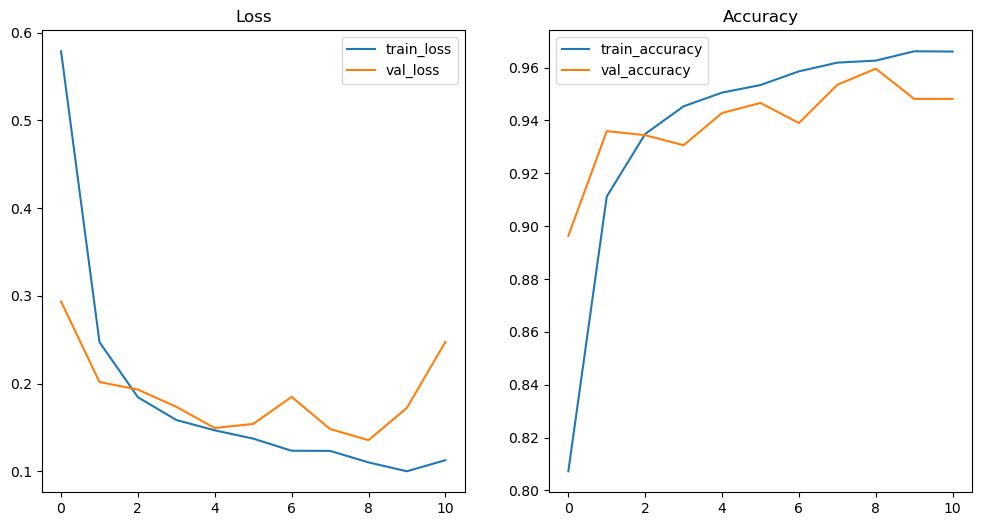

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

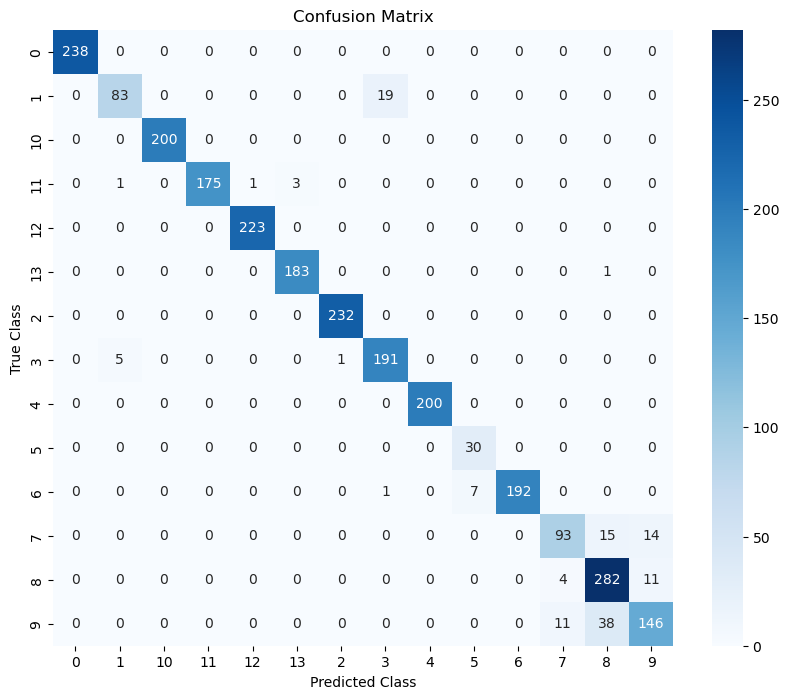

In [20]:
cm = confusion_matrix(generator_test.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [34]:
image_path_show
true_label_show
predicted_label_show

'3'

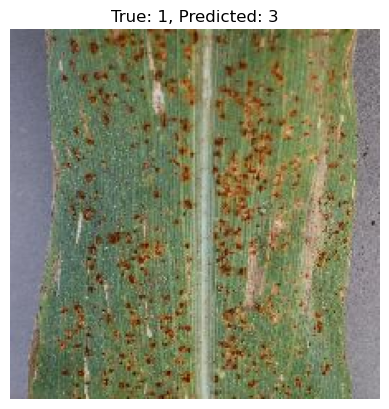

In [50]:
img_width, img_height= 224, 224
misclassified_images = []
for i in range(len(y_pred)):
    if y_pred[i] != generator_test.classes[i]:
        img_path = generator_test.filepaths[i]
        true_label = generator_test.classes[i]
        predicted_label = y_pred[i]
        misclassified_images.append((img_path, true_label, predicted_label))


num_display = 1
for img_path, true_label, predicted_label in misclassified_images[:num_display]:
    img = load_img(img_path, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()
    
    image_path_show = img
    true_label_show = class_labels[true_label]
    predicted_label_show = class_labels[predicted_label]

# **XAI**

In [123]:
def superimpose(img, cam):
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    alpha = 0.5 
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return img, heatmap, superimposed_img


In [88]:
def grad_cam(model, x, layer_name):
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    
    grad_model = tf.keras.models.Model([model.inputs], [conv_output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(x)
        loss = predictions[0, cls]
    
    grads = tape.gradient(loss, conv_output)
    grads_val = grads.numpy()[0]
    output = conv_output.numpy()[0]
    
    weights = np.mean(grads_val, axis=-1) 
    
    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)
    
    max_value = np.max(cam)
    if max_value != 0:
        cam /= max_value 
    
    return cls, cam

In [90]:
def plot_org_img_and_cam_heatmap(
        model, 
        cam_func, 
        superimpose, 
        img, 
        cls_true, 
        class_to_label, 
        cam_name,
    ):
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    img = np.uint8(img)

    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title("original image")
    axs[0].axis("off")

    axs[1].imshow(heatmap)
    axs[1].set_title("heatmap")
    axs[1].axis("off")

    axs[2].imshow(superimposed_img)
    axs[2].set_title("superimposed image")
    axs[2].axis("off")

    title = "CAM name: " + cam_name + "<====> True label: " + cls_true + "<====> Predicted label : " + class_to_label
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [54]:
image_path_show
true_label_show
predicted_label_show

'3'

In [56]:
img_array = image.img_to_array(image_path_show)
# print(img_array)

In [57]:
img_array.shape

(224, 224, 3)

1/1 [==============================] - 0s 40ms/step


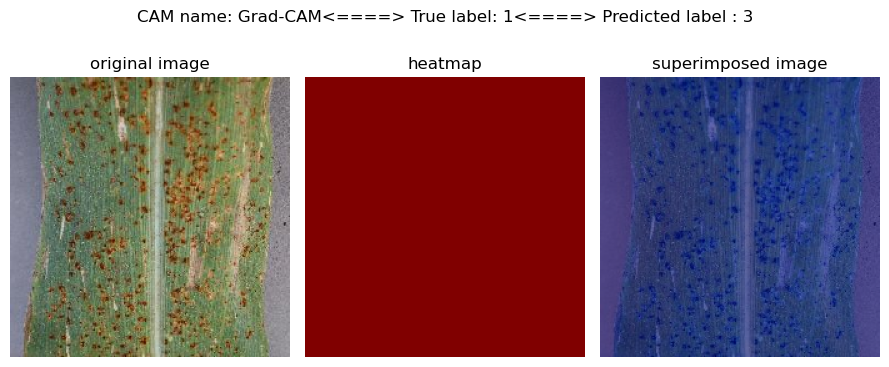

In [124]:
plot_org_img_and_cam_heatmap(
    model=new_model, 
    cam_func=grad_cam,
    superimpose=superimpose,
    img=img_array,
    cls_true=true_label_show, 
    class_to_label=predicted_label_show, 
    cam_name="Grad-CAM",
)